$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/shaigue/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/shaigue/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/shaigue/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


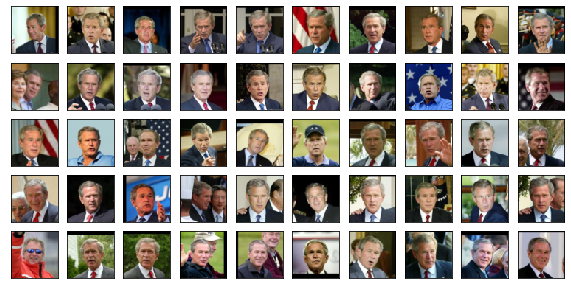

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (features_extractor): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (flattener): Linear(in_features=16384, out_features=1, bias=True)
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (deflattener): Linear(in_features=128, out_features=16384, bias=True)
  (feature_decoder): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (10): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

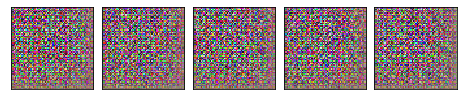

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 8, 'data_label': 1, 'label_noise': 0.25, 'discriminator_optimizer': {'type': 'SGD', 'lr': 0.0001}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.003}}


**TODO**:
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training.

--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.60it/s]
Discriminator loss: 2.3436680401072785
Generator loss:     0.34391144268652973


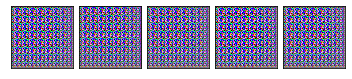

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.48it/s]
Discriminator loss: 2.7336414842044605
Generator loss:     0.26908852773554187


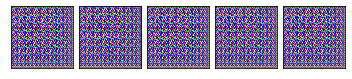

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.57it/s]
Discriminator loss: 3.2096556354971493
Generator loss:     0.18867351728327134


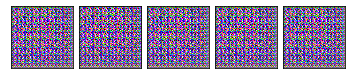

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 3.3083520777085247
Generator loss:     0.18788236467277303


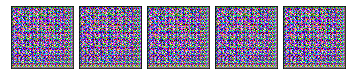

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 3.419401729808134
Generator loss:     0.17647837540682623


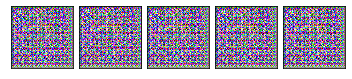

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.15it/s]
Discriminator loss: 3.4637762097751392
Generator loss:     0.18285677713506363


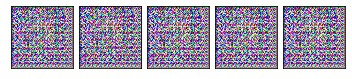

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.68it/s]
Discriminator loss: 3.4302727334639607
Generator loss:     0.20072029706309824


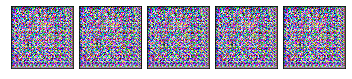

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.71it/s]
Discriminator loss: 3.4082148215349983
Generator loss:     0.2091155402800616


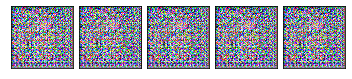

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.37it/s]
Discriminator loss: 3.4074808569515453
Generator loss:     0.21777085784603567


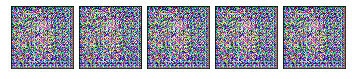

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Discriminator loss: 3.344378303079044
Generator loss:     0.24220593974870794


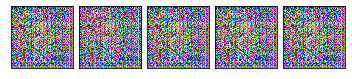

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 3.235145498724545
Generator loss:     0.26608803342370424


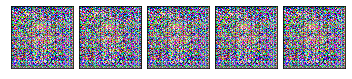

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
Discriminator loss: 3.094945234410903
Generator loss:     0.29564513704356027


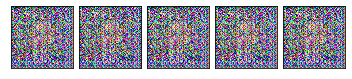

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 2.9942272831411922
Generator loss:     0.3126017696717206


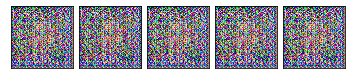

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.54it/s]
Discriminator loss: 2.9717524191912483
Generator loss:     0.3163469135761261


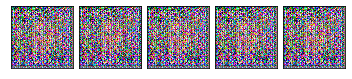

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 2.90087049147662
Generator loss:     0.3275830079527462


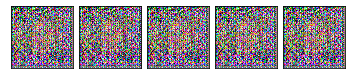

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 2.8415223289938534
Generator loss:     0.34725115404409523


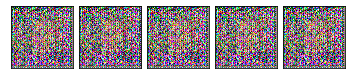

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.61it/s]
Discriminator loss: 2.7117827499614044
Generator loss:     0.37236132516580467


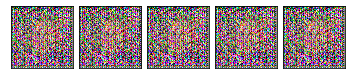

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.67it/s]
Discriminator loss: 2.6261468915378345
Generator loss:     0.3936477724243613


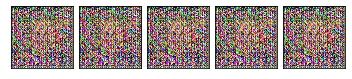

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.61it/s]
Discriminator loss: 2.6240976277519676
Generator loss:     0.3839171704124002


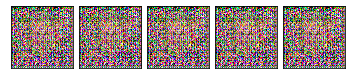

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.59it/s]
Discriminator loss: 2.5935791941250073
Generator loss:     0.38825659541522756


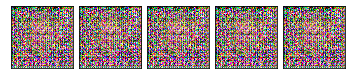

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.69it/s]
Discriminator loss: 2.5069761276245117
Generator loss:     0.40883591771125793


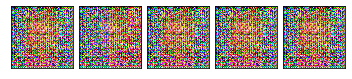

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 2.4822540703941796
Generator loss:     0.4090736175284666


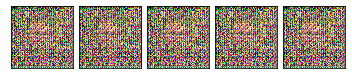

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 2.4112651348114014
Generator loss:     0.42541487602626576


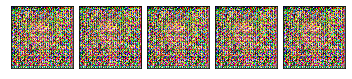

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 2.3563210403217987
Generator loss:     0.43602275497773113


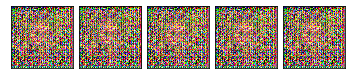

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 2.313901789048139
Generator loss:     0.4467528234509861


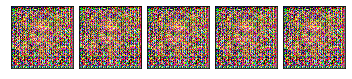

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.40it/s]
Discriminator loss: 2.2619817958158603
Generator loss:     0.46214788275606494


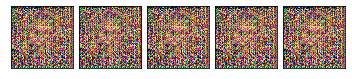

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.67it/s]
Discriminator loss: 2.201178747064927
Generator loss:     0.4792812887360068


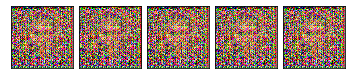

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.71it/s]
Discriminator loss: 2.1438827374402214
Generator loss:     0.49518026849802804


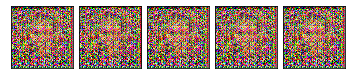

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.93it/s]
Discriminator loss: 2.0940025834476246
Generator loss:     0.5036662326139563


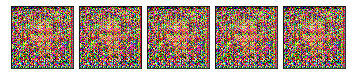

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Discriminator loss: 2.052296484217924
Generator loss:     0.5060470034094418


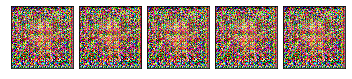

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Discriminator loss: 2.0382446751875034
Generator loss:     0.4989255789448233


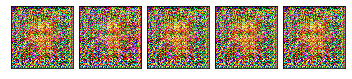

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 2.0471277517430924
Generator loss:     0.49689646678812366


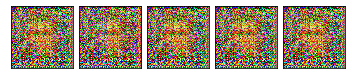

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 2.0002809552585377
Generator loss:     0.516504613792195


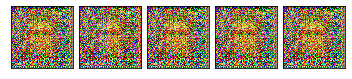

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 1.9821063981336706
Generator loss:     0.518689842785106


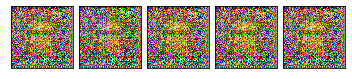

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 1.9696179137510412
Generator loss:     0.5231234746820786


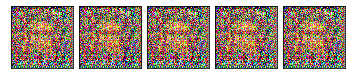

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 1.9534021686105167
Generator loss:     0.5302100146518034


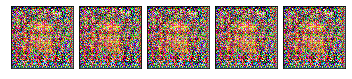

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.60it/s]
Discriminator loss: 1.9422232824213364
Generator loss:     0.5323652625083923


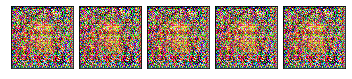

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.66it/s]
Discriminator loss: 1.912052357898039
Generator loss:     0.5433223247528076


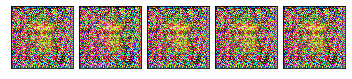

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.70it/s]
Discriminator loss: 1.915536039015826
Generator loss:     0.537410648430095


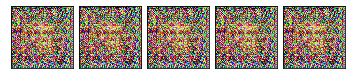

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.28it/s]
Discriminator loss: 1.8645983092925127
Generator loss:     0.5617376741241006


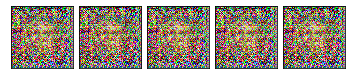

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.47it/s]
Discriminator loss: 1.8176810881670784
Generator loss:     0.578305861529182


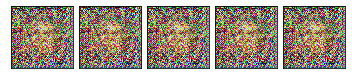

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.66it/s]
Discriminator loss: 1.8154166516135721
Generator loss:     0.5717152497347664


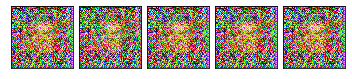

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
Discriminator loss: 1.8450957045835608
Generator loss:     0.5565954411731047


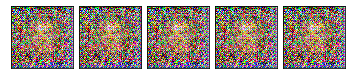

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 1.8353518878712374
Generator loss:     0.5699188218397253


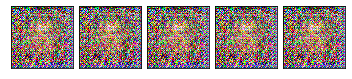

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Discriminator loss: 1.8214761229122387
Generator loss:     0.5734889472232145


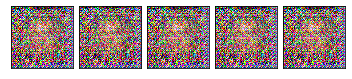

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 1.7680394649505615
Generator loss:     0.5969822862569023


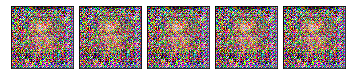

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 1.7760402314803179
Generator loss:     0.5809608031721676


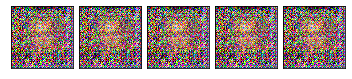

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
Discriminator loss: 1.7674593995599186
Generator loss:     0.5853847054874196


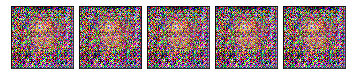

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 1.749338893329396
Generator loss:     0.597197809640099


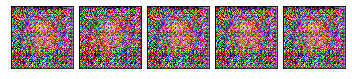

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Discriminator loss: 1.7406531852834366
Generator loss:     0.5988861076972064


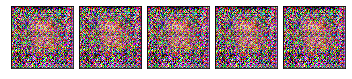

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Discriminator loss: 1.7203000643674065
Generator loss:     0.5991359423188602


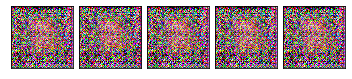

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.62it/s]
Discriminator loss: 1.7249266259810503
Generator loss:     0.5945234964875614


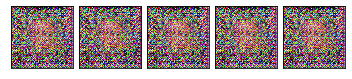

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.63it/s]
Discriminator loss: 1.7393333070418413
Generator loss:     0.591340580407311


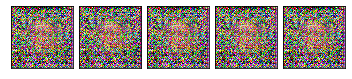

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.63it/s]
Discriminator loss: 1.743925269912271
Generator loss:     0.5940640358363881


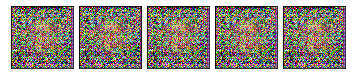

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.68it/s]
Discriminator loss: 1.6716786062016207
Generator loss:     0.6348633450620315


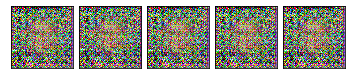

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.54it/s]
Discriminator loss: 1.6377477295258467
Generator loss:     0.6403075491680819


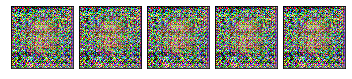

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.61it/s]
Discriminator loss: 1.6386869865305282
Generator loss:     0.6392950801288381


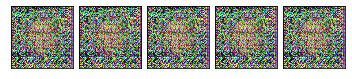

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.65it/s]
Discriminator loss: 1.6683276400846594
Generator loss:     0.6148941622060888


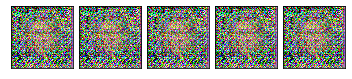

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 1.694849456057829
Generator loss:     0.6075126037878149


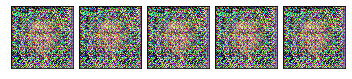

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.68it/s]
Discriminator loss: 1.6553572135813095
Generator loss:     0.6311266352148617


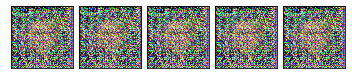

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.65it/s]
Discriminator loss: 1.646234105615055
Generator loss:     0.6345301936654484


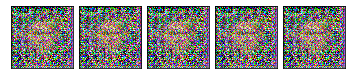

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.65it/s]
Discriminator loss: 1.623407006263733
Generator loss:     0.6409088232937981


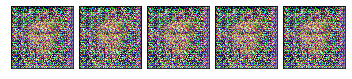

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.43it/s]
Discriminator loss: 1.6409940719604492
Generator loss:     0.6254801995613996


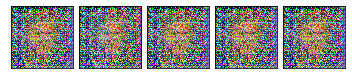

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.36it/s]
Discriminator loss: 1.6277082317015703
Generator loss:     0.6384783071630141


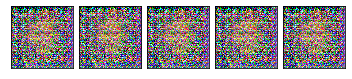

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
Discriminator loss: 1.6370042211869185
Generator loss:     0.625059047166039


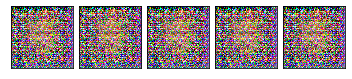

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 1.61666641515844
Generator loss:     0.6355238626984989


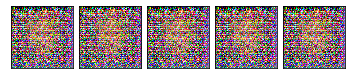

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.92it/s]
Discriminator loss: 1.6017847902634565
Generator loss:     0.6395827391568352


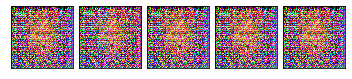

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.54it/s]
Discriminator loss: 1.5821174453286564
Generator loss:     0.6539079652113073


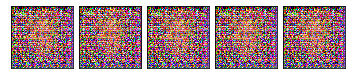

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.55it/s]
Discriminator loss: 1.5733655060038847
Generator loss:     0.6572114439571605


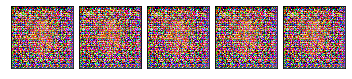

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.49it/s]
Discriminator loss: 1.5546432593289543
Generator loss:     0.6642739141688627


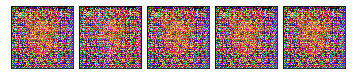

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.53it/s]
Discriminator loss: 1.5601380782968857
Generator loss:     0.662945501944598


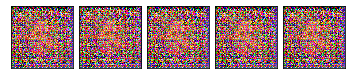

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.55it/s]
Discriminator loss: 1.55708646774292
Generator loss:     0.6616516954758588


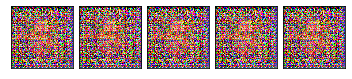

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.47it/s]
Discriminator loss: 1.5801724475972794
Generator loss:     0.6474042079027962


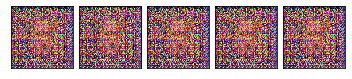

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 1.5782384030959185
Generator loss:     0.6502909590216244


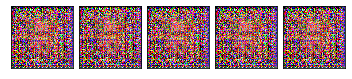

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
Discriminator loss: 1.5543807744979858
Generator loss:     0.6653121043654049


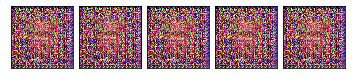

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.47it/s]
Discriminator loss: 1.5325011575923246
Generator loss:     0.6775652029935051


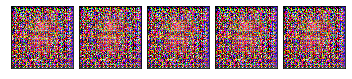

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.52it/s]
Discriminator loss: 1.547381323926589
Generator loss:     0.667226651135613


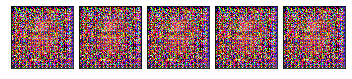

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.54it/s]
Discriminator loss: 1.5598399008021635
Generator loss:     0.6582677750026479


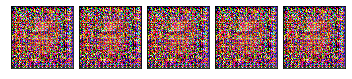

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.56it/s]
Discriminator loss: 1.5156857897253597
Generator loss:     0.6887821169460521


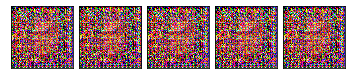

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.61it/s]
Discriminator loss: 1.5151312351226807
Generator loss:     0.6783488287645227


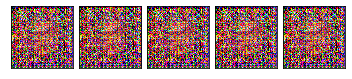

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.63it/s]
Discriminator loss: 1.506296669735628
Generator loss:     0.6863947510719299


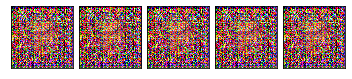

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.67it/s]
Discriminator loss: 1.4817351874183207
Generator loss:     0.7004400877391591


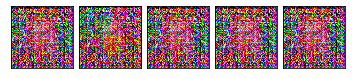

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.56it/s]
Discriminator loss: 1.5054875962874468
Generator loss:     0.682797743993647


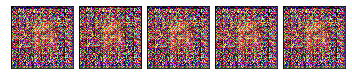

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.63it/s]
Discriminator loss: 1.5305144155726713
Generator loss:     0.6684384661562303


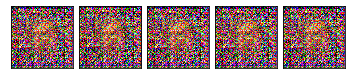

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.61it/s]
Discriminator loss: 1.5206395457772648
Generator loss:     0.6828041322091046


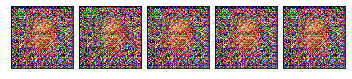

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.66it/s]
Discriminator loss: 1.5138021427042343
Generator loss:     0.687745609704186


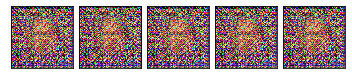

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.63it/s]
Discriminator loss: 1.5257288077298332
Generator loss:     0.6732127280796275


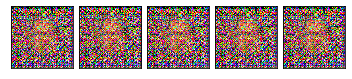

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.54it/s]
Discriminator loss: 1.5134173912160538
Generator loss:     0.6813807943288017


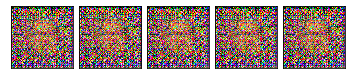

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.58it/s]
Discriminator loss: 1.5081504933974321
Generator loss:     0.6874192742740407


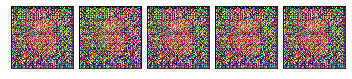

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.64it/s]
Discriminator loss: 1.50563962319318
Generator loss:     0.6885231487891253


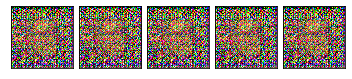

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.70it/s]
Discriminator loss: 1.4943244457244873
Generator loss:     0.6928024011499742


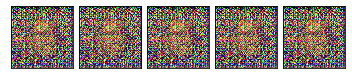

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.66it/s]
Discriminator loss: 1.4875565136180204
Generator loss:     0.6948376893997192


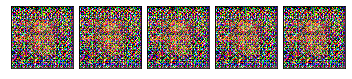

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.47it/s]
Discriminator loss: 1.4617613483877743
Generator loss:     0.7128234084914712


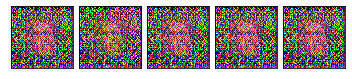

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.61it/s]
Discriminator loss: 1.4725490668240715
Generator loss:     0.709392786026001


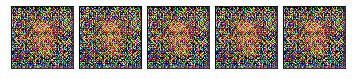

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.66it/s]
Discriminator loss: 1.469574304187999
Generator loss:     0.7135803909862742


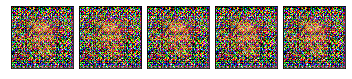

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.71it/s]
Discriminator loss: 1.44142368961783
Generator loss:     0.7327763964148128


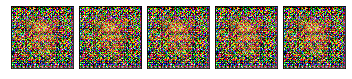

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:05<00:00,  4.01it/s]
Discriminator loss: 1.4232681288438684
Generator loss:     0.7320291435017305


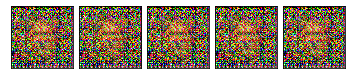

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 1.4357386967715096
Generator loss:     0.7149857422884773


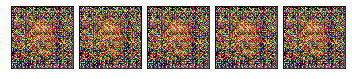

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.68it/s]
Discriminator loss: 1.4604356990141028
Generator loss:     0.697940377628102


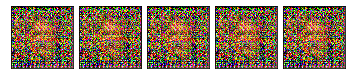

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.66it/s]
Discriminator loss: 1.439229495385114
Generator loss:     0.7244616817025578


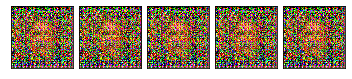

In [12]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


*** Images Generated from best model:


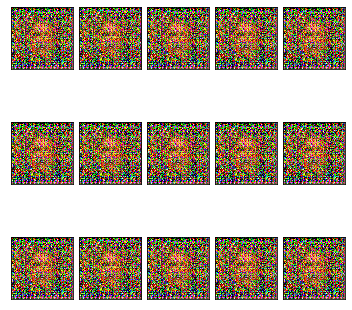

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [14]:
from cs236605.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [15]:
display_answer(hw3.answers.part3_q1)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [16]:
display_answer(hw3.answers.part3_q2)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [17]:
display_answer(hw3.answers.part3_q3)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

